## Using the bottleneck features of a pre-trained network along with data argumentation plus base model fine-tuning for classifying Dog Breeds 

In this short book we will investigate the effect of how data argumentation, transfer learning and fine tuning of pre-trained network can help us achieve high accuracy for predicting the dog breed given a dog image with the additional caveat that we only have a sparse dataset available.

We will consider 50 dogbreeds consisting of:
- 2871 training dog images (avg. of 57 per class)
- 353 validation dog images (avg. of 7 per class)
- 365 test dog images (avg. of 7 per class)


We will start out by transfer learning from imagenet. We check to see the effect of using below optimizer for the transfer learning: <br>
> __model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])__<br>

For fine tuning the last layers in the pre-trained network we use the stochastic gradient descent optimizer with low learning rates and decays while keeping a high momentum of 0.9: <br>
>  __sgd = SGD(lr=learning_rate, decay=decay, momentum=0.9, nesterov=True)__ <br>
>  __model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])__ <br>


### Inception V3 architecture

The basic adaptations for this architecture are:

- Reduce the number of convolutions to maximum 3x3
- Increase the general depth of the networks
- Use the width increase technique at each layer to improve feature combination

The following diagram illustrates how the improved inception module can be interpreted:
<img src=./InceptionV3.jpg>

<BR><BR>
And this is a representation of the whole V3 architecture, with many instances of the common building module:
<img src=./InceptionV3.png>


### The Inception V3 model summary

The base model and its layers:

In [1]:
from keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False) #include_top=False excludes final FC layer
base_model.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 32 864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, None, None, 32 96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, None, None, 32 0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

### The Data

The structure of our training, validation and test datasets are illustrated below. This structure are dictated by using the ImageDataGenerator and flow_from_directory() functionality of Keras, so we need to create a directory structure where images of each class sits within its own sub-directory in the training, validation and test directories.

<img src=./Image_structure_hl.png>

<img src=./Image_structure_ll.png>

<img src=./Image_structure_details.png>

Make sure all the sub-directories (classes) in the training set are present in the validation and test set also. And, remember that the names of the sub-directories will be the names of your classes (labels).

### Constants

The constants of our experiment:

In [2]:
# The pixel size we will use for our images (of various resolution)
WIDTH, HEIGHT = 299, 299

# Number of epochs to train model on
EPOCHS = 20

# Batch size used by flow_from_directory and predict_generator 
BATCH_SIZE = 16

# Note: For each batch, gradients will be computed and updates will be made 
# to the weights of the network automatically. One iteration over all the 
# training set is referred to as an epoch

# Layer from which we will start retraining our already pretrained base model (Xception, Inception or .. whatever)
LAYERS_TO_FREEZE = 172 # We will come in at NB_IV3

# Note for Xception a suitable value be around 126, at least to start with

# The number of outcome classes, that is, number of dog breeds
NO_OF_CLASSES = 50

# location of the directiories containing the same classes
TRAIN_DATA_DIR = 'dogImages50/train'
VALID_DATA_DIR = 'dogImages50/valid'
TEST_DATA_DIR = 'dogImages50/test'

### The top layer

Now we introduce a small fully-connected network - the top model. We will keep the top model small and light as we are only interested in seeing how the transfer learned and the fine tuned models perform.

In [3]:
from keras.models import Model  
from keras.layers import Dropout, Dense, GlobalAveragePooling2D  

top_layer = base_model.output
top_layer = GlobalAveragePooling2D()(top_layer)
top_layer = Dropout(0.5)(top_layer)
top_layer = Dense(256, activation='relu')(top_layer) 
top_layer = Dropout(0.5)(top_layer)
top_layer = Dense(NO_OF_CLASSES, activation='softmax')(top_layer) 

# Combine the base and top model
model = Model(inputs=base_model.inputs, outputs=top_layer)

### Preparing for transfer learning

In [4]:
# Freeze all layers in the base model and compile the entire model
def use_transfer_learning():
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Preparing for fine-tuning base model

The features learned by low-level convolutional blocks are more general, less abstract than those found higher-up, so it is sensible to only fine-tune the last blocks/layers (more specialized features).

In [5]:
from keras.optimizers import SGD

# Allow any layer after LAYERS_TO_FREEZE to get re-trained on our dataset. Fine-tuning 
# should be done with a very slow learning rate, and typically with the SGD optimizer 
# rather than an adaptative learning rate optimizer such as RMSProp. This is to make 
# sure that the magnitude of the updates stays very small, so as not to wreck the 
# previously learned features. 
def use_finetuning(lr, decay):    
    for layer in base_model.layers[:LAYERS_TO_FREEZE]:
        layer.trainable = False
    for layer in base_model.layers[LAYERS_TO_FREEZE:]:
        layer.trainable = True
    sgd = SGD(lr=lr, decay=decay, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

### The Image Generators

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

In [6]:
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

# this is the augmentation configuration we will use for training
train_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30, # value in degrees (0-180), a range within which to randomly rotate pictures
    width_shift_range=0.2,  # ranges (fraction of total width or height) within which to randomly translate 
    height_shift_range=0.2, # pictures vertically or horizontally
    zoom_range=0.2, # randomly zooming inside pictures
    horizontal_flip=True # randomly flipping half of the images horizontally
)

# this is the augmentation configuration we will use for training    
valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# this is a generator that will read pictures found in subfolders of 'data/train', 
# and indefinitely generate batches of augmented image data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
)

# this is a similar generator, for validation data
valid_generator = valid_datagen.flow_from_directory(
    VALID_DATA_DIR,
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
)

Found 2871 images belonging to 50 classes.
Found 351 images belonging to 50 classes.


### Training time



transfer learning starting...
Epoch 1/10
180/180 [==============================] - 107s - loss: 3.2641 - acc: 0.2112 - val_loss: 1.5501 - val_acc: 0.6610
Epoch 2/10
180/180 [==============================] - 72s - loss: 1.8620 - acc: 0.5173 - val_loss: 0.7412 - val_acc: 0.8205
Epoch 3/10
180/180 [==============================] - 72s - loss: 1.4504 - acc: 0.6063 - val_loss: 0.6024 - val_acc: 0.8291
Epoch 4/10
180/180 [==============================] - 72s - loss: 1.2747 - acc: 0.6431 - val_loss: 0.6258 - val_acc: 0.7949
Epoch 5/10
180/180 [==============================] - 71s - loss: 1.1376 - acc: 0.6851 - val_loss: 0.5406 - val_acc: 0.8205
Epoch 6/10
180/180 [==============================] - 72s - loss: 1.1044 - acc: 0.6839 - val_loss: 0.4421 - val_acc: 0.8604
Epoch 7/10
180/180 [==============================] - 72s - loss: 1.0224 - acc: 0.7053 - val_loss: 0.6253 - val_acc: 0.8006
Epoch 8/10
180/180 [==============================] - 72s - loss: 1.0196 - acc: 0.7071 - val_loss: 0.

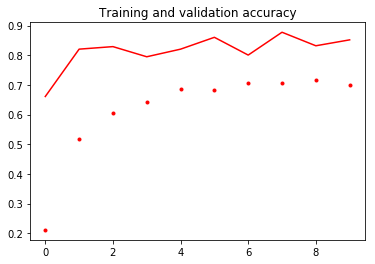

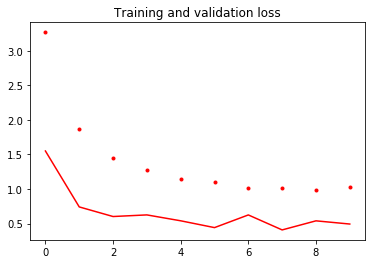

fine-tuning starting...
Epoch 1/20
180/180 [==============================] - 90s - loss: 0.7761 - acc: 0.7646 - val_loss: 0.2545 - val_acc: 0.9060
Epoch 2/20
180/180 [==============================] - 87s - loss: 0.5830 - acc: 0.8212 - val_loss: 0.2743 - val_acc: 0.9088
Epoch 3/20
180/180 [==============================] - 86s - loss: 0.4672 - acc: 0.8573 - val_loss: 0.2973 - val_acc: 0.9003
Epoch 4/20
180/180 [==============================] - 86s - loss: 0.4367 - acc: 0.8652 - val_loss: 0.2718 - val_acc: 0.8889
Epoch 5/20
180/180 [==============================] - 87s - loss: 0.3613 - acc: 0.8854 - val_loss: 0.1957 - val_acc: 0.9345
Epoch 6/20
180/180 [==============================] - 86s - loss: 0.3132 - acc: 0.8962 - val_loss: 0.2550 - val_acc: 0.9117
Epoch 7/20
180/180 [==============================] - 86s - loss: 0.3065 - acc: 0.9072 - val_loss: 0.2028 - val_acc: 0.9288
Epoch 8/20
180/180 [==============================] - 87s - loss: 0.2974 - acc: 0.9045 - val_loss: 0.1657 - 

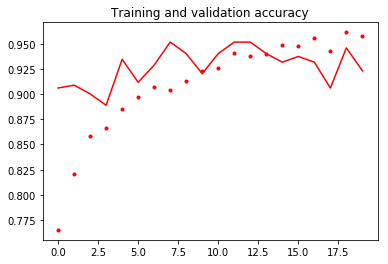

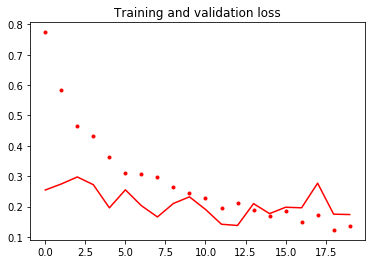

fine-tuning starting (with decreasing learning rate) ...
Epoch 1/200
180/180 [==============================] - 109s - loss: 1.6285 - acc: 0.5481 - val_loss: 2.3801 - val_acc: 0.5641
Epoch 2/200
180/180 [==============================] - 90s - loss: 1.2210 - acc: 0.6484 - val_loss: 1.2119 - val_acc: 0.7407
Epoch 3/200
180/180 [==============================] - 90s - loss: 1.0384 - acc: 0.6975 - val_loss: 1.1913 - val_acc: 0.6923
Epoch 4/200
180/180 [==============================] - 90s - loss: 0.9253 - acc: 0.7525 - val_loss: 0.7660 - val_acc: 0.8120
Epoch 5/200
180/180 [==============================] - 86s - loss: 0.8015 - acc: 0.7648 - val_loss: 0.8465 - val_acc: 0.7977
Epoch 6/200
180/180 [==============================] - 90s - loss: 0.7454 - acc: 0.7896 - val_loss: 0.5661 - val_acc: 0.8519
Epoch 7/200
180/180 [==============================] - 86s - loss: 0.6050 - acc: 0.8326 - val_loss: 0.7922 - val_acc: 0.7920
Epoch 8/200
180/180 [==============================] - 86s - loss: 

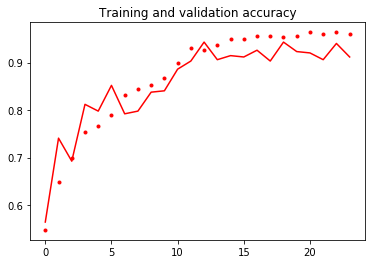

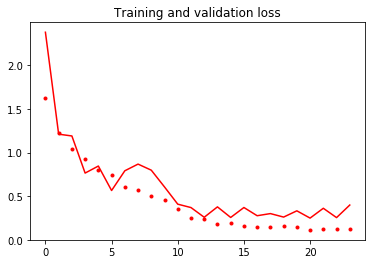

In [7]:
import math
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

# A little plot helper allowing us to visualise the result
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.show()

# A decreasing learning rate schedule (continuous decrease)
def continuous_decay(epoch):
    initial_lrate = 0.01
    lr = initial_lrate * (0.1 ** int(epoch / 10))
    return lr

# Another decreasing learning rate schedule (stepped decrease)
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 5.0
    lr = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

# Use transfer learning and fine-tuning to train a network on a given dataset
def train():
    no_of_train_samples = len(train_generator.filenames)
    no_of_valid_samples = len(valid_generator.filenames)

    # We calculate the number of itrations ourselves as there are a small bug in predict_generator
    # and fit_generator when working on batches when the number of samples are not divisible
    # by the batch size
    no_of_train_iterations = int(math.ceil(no_of_train_samples / BATCH_SIZE))  
    no_of_valid_iterations = int(math.ceil(no_of_valid_samples / BATCH_SIZE))  

    print("transfer learning starting...")
    use_transfer_learning()
    history_tl = model.fit_generator(
        train_generator,
        steps_per_epoch=no_of_train_iterations,
        epochs=10,
        validation_data=valid_generator,
        validation_steps=no_of_valid_iterations,
        verbose=1)    
    plot_training(history_tl)

    print("fine-tuning starting...")
    use_finetuning(lr=5e-4, decay=5e-5)
    history_ft = model.fit_generator(
        train_generator,
        steps_per_epoch=no_of_train_iterations,
        epochs=EPOCHS,
        validation_data=valid_generator,
        validation_steps=no_of_valid_iterations,
        verbose=1)    
    plot_training(history_ft)

    print("fine-tuning starting (with decreasing learning rate) ...")
    # Note another option for decreasing learning rate could be ReduceLROnPlateau (https://keras.io/callbacks/)
    use_finetuning(lr = 0, decay = 0) # Let the learning schedule feed the lr and decay into the fitting process
    history_ft_lr = model.fit_generator(
        train_generator,
        steps_per_epoch=no_of_train_iterations,
        epochs=10*EPOCHS, # Running many epochs expecting early stopping to stop training if no improvements seen
        validation_data=valid_generator,
        validation_steps=no_of_valid_iterations,
        callbacks=[LearningRateScheduler(continuous_decay), 
                   ModelCheckpoint('model_Xcep_CD_LR.h5', save_best_only=True),
                   EarlyStopping(monitor='val_loss', min_delta=0.1, patience=10)],
        verbose=1)    
    plot_training(history_ft_lr)

    
# Lets train away
train()


Great success but maybe we can do better by considering:
- use of L1 or L2 regularization (https://keras.io/regularizers/)
- better loss function
- more aggresive data augmentation (consider increase valid. image count)
- more aggressive dropout
- fine-tuning additional convolutional block/layers 